In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [16]:
GC_variable_const_proms = '../../data/genes/responsivepromoters_GC_content.txt'
promoters_file = '../../data/genes/constitutive-variable-random_100_each.csv'

In [18]:
promoters = pd.read_csv(promoters_file, header=0)
promoters = promoters[['promoter_AGI','gene_type']]
GC_content = pd.read_table(GC_variable_const_proms, delim_whitespace=True, header=None)
cols = ['promoter_AGI', 'percentage_GC_content']
GC_content.columns = cols
#merge to limit to genes of interest
GC_content = pd.merge(promoters, GC_content)
GC_content

,promoter_AGI,gene_type,percentage_GC_content
0,AT4G34270,housekeeping,32.6
1,AT3G32260,housekeeping,27.4
2,AT1G59830,housekeeping,25.5
3,AT4G33380,housekeeping,41.6
4,AT2G28390,housekeeping,21.5
...,...,...,...
295,AT5G13410,randCont,41.3
296,AT5G56090,randCont,27.2
297,AT5G05170,randCont,34.6
298,AT3G18110,randCont,39.8


## plot

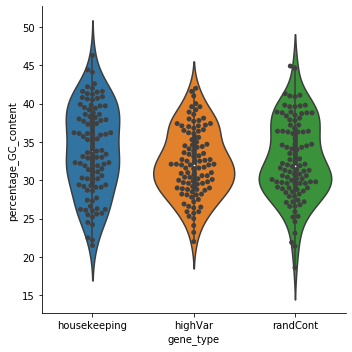

In [27]:
plot = sns.catplot(x="gene_type", y="percentage_GC_content", data=GC_content, kind='violin')
#plot points
ax = sns.swarmplot(x="gene_type", y="percentage_GC_content", data=GC_content, color=".25").get_figure().savefig('../../data/plots/GC_content/var_const_GCcontent_violin.pdf', format='pdf')

In [23]:
pd.Categorical(GC_content.gene_type)
names = GC_content.gene_type.unique()
for name in names:
    print(name)

housekeeping
highVar
randCont


In [26]:
#variable vs housekeeping
stats.mannwhitneyu(GC_content.percentage_GC_content[GC_content.gene_type == names[1]], 
               GC_content.percentage_GC_content[GC_content.gene_type == names[2]])

MannwhitneyuResult(statistic=4792.5, pvalue=0.3064929043564655)